In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
0,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
1,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
2,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
3,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
4,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a


In [4]:
ais_nan = ais

In [5]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[(ais_nan['TH'] >= 360)|(ais_nan['TH'] <= 0) , 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [10]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [13]:
ais_dropped.loc[(ais_dropped['TH'] <= 0.0) & (ais_dropped['TH'] >= 0.0)].describe()

,StartLatitude,StartLongitude,EndLatitude,EndLongitude,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,u'All Positions Before Filtering')

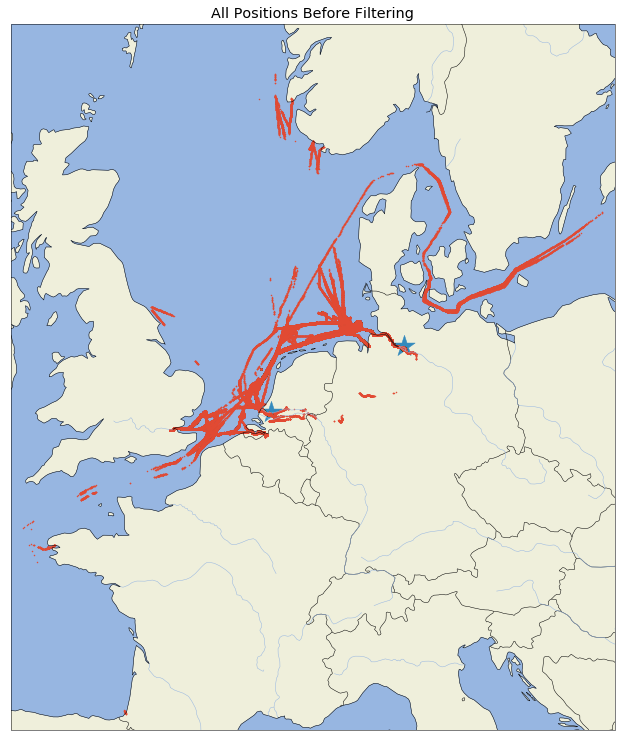

In [14]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

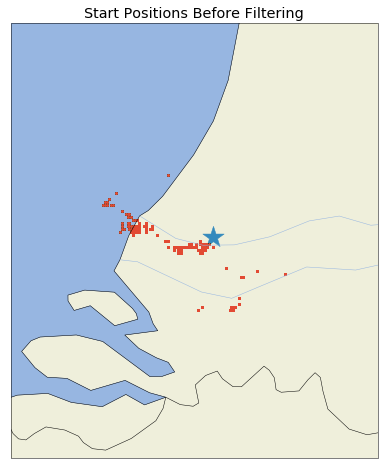

In [15]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

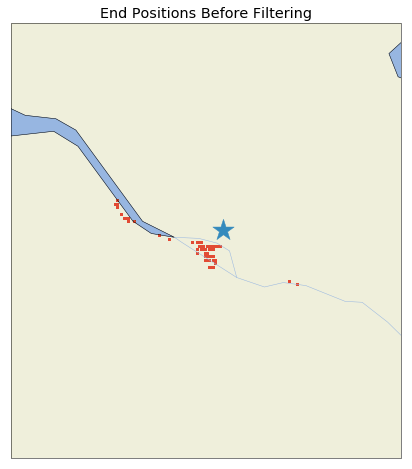

In [16]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [17]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 2.45) | (ais_dropped['Longitude'] > 10.66)
outside_lat_mask = (ais_dropped['Latitude'] < 51.49) | (ais_dropped['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

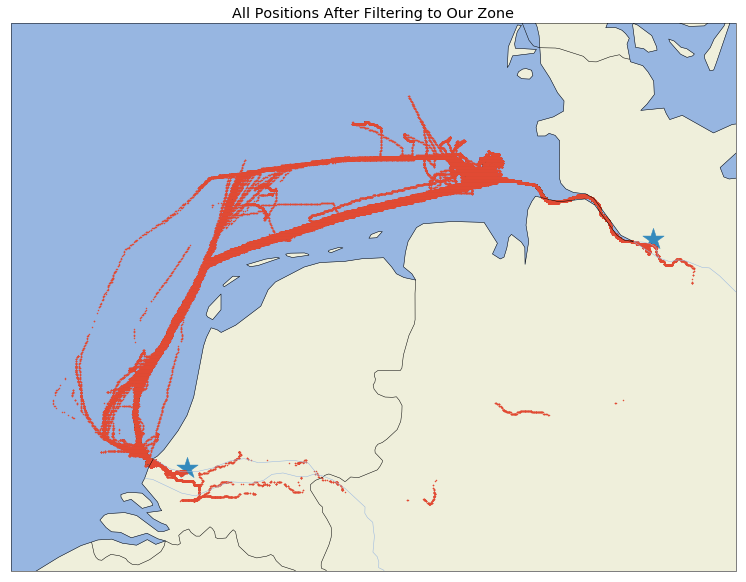

In [18]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

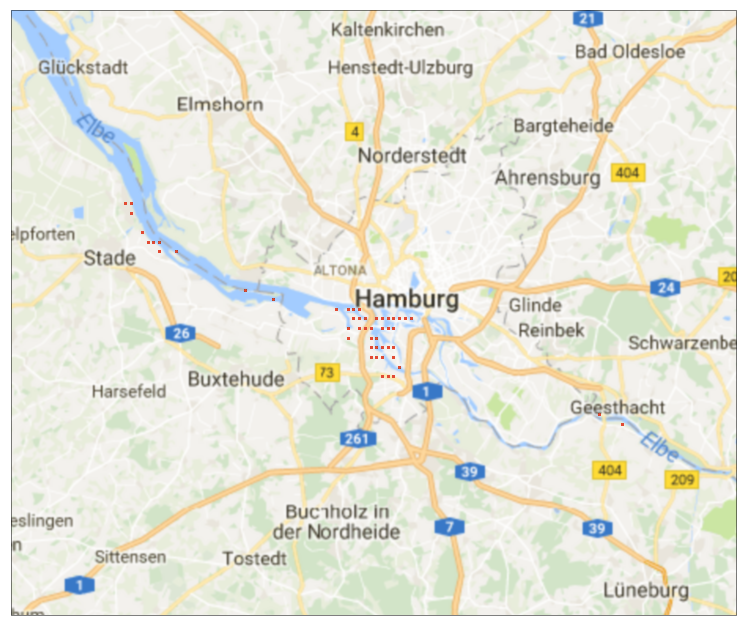

In [19]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [20]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 9.81].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

C:\Users\eijoa\Anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


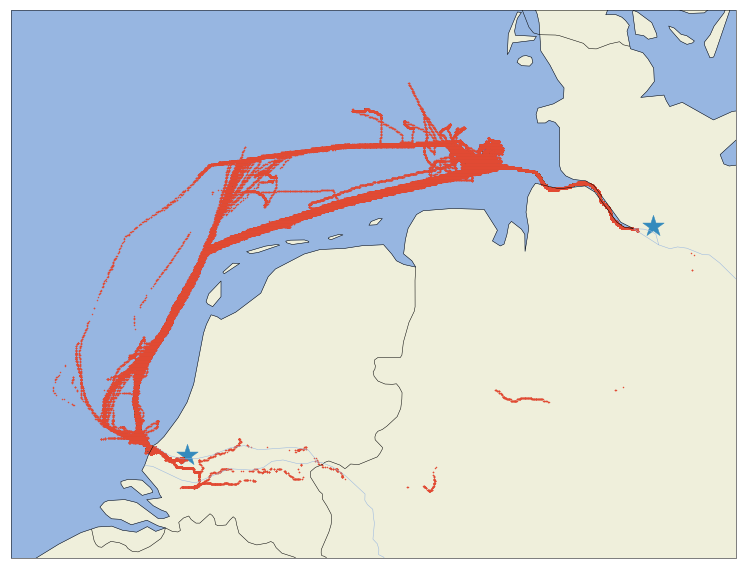

In [21]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [22]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

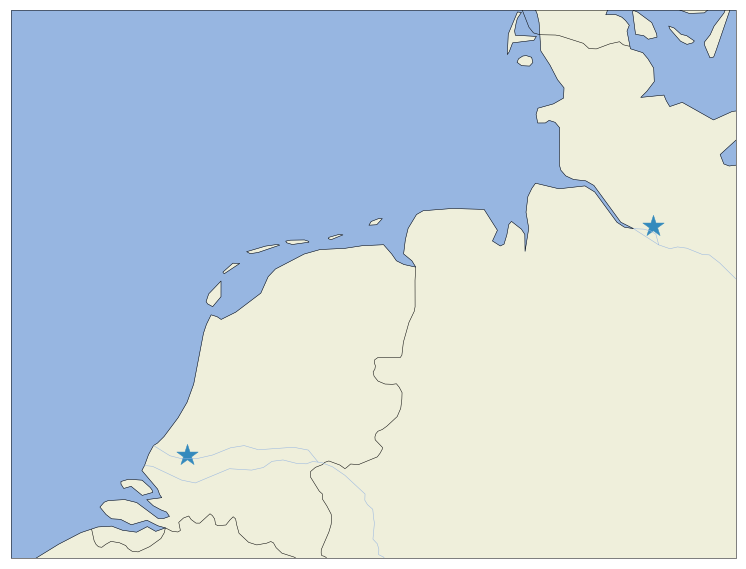

In [23]:
aismap.plot_trips(ais_tts, 'TravelTime')

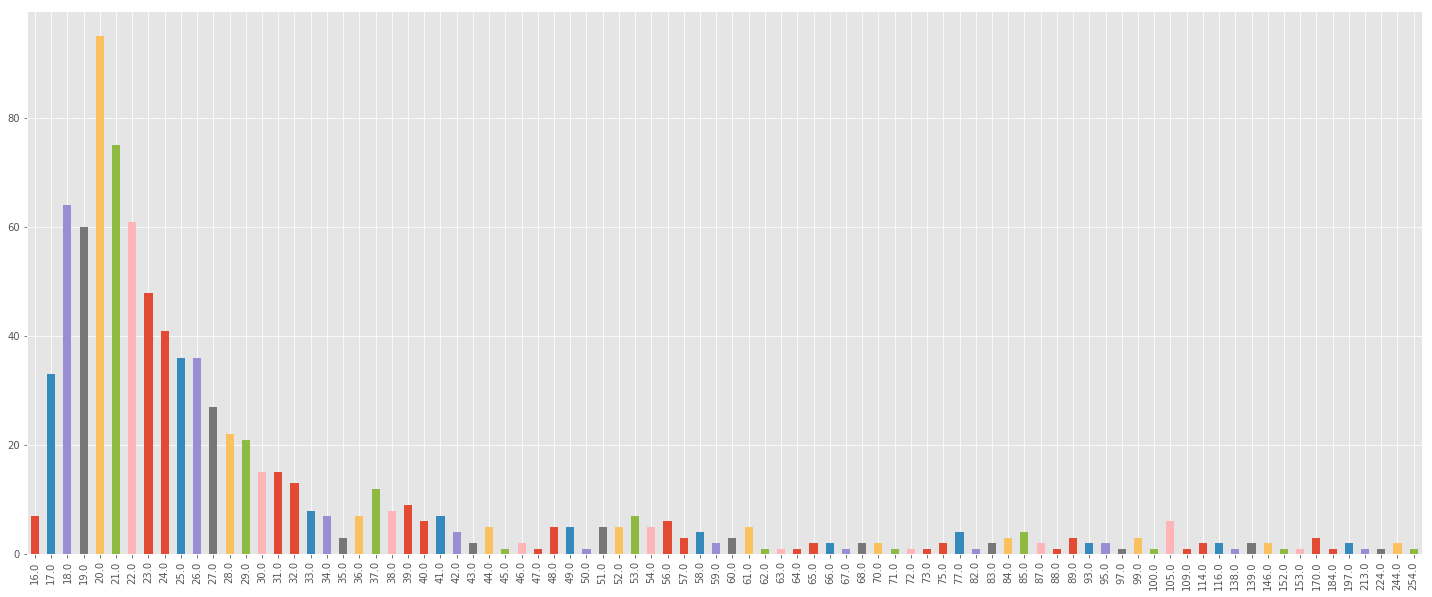

In [24]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

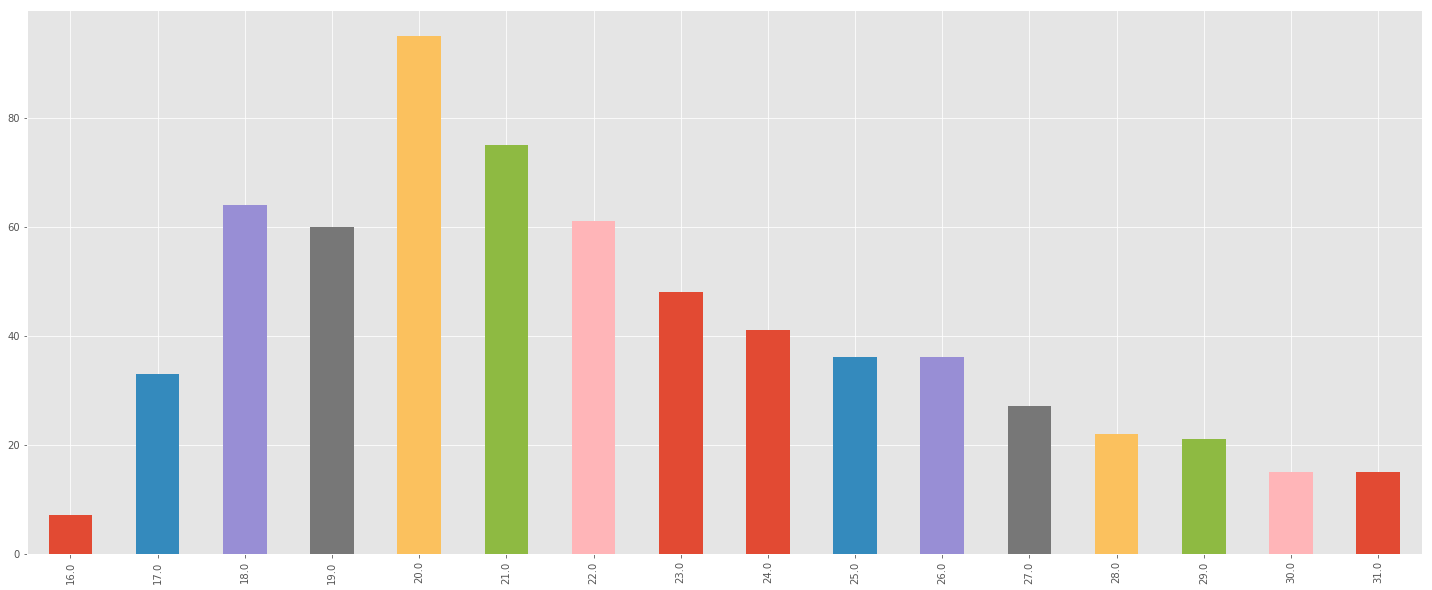

In [25]:
travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [26]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.75)]

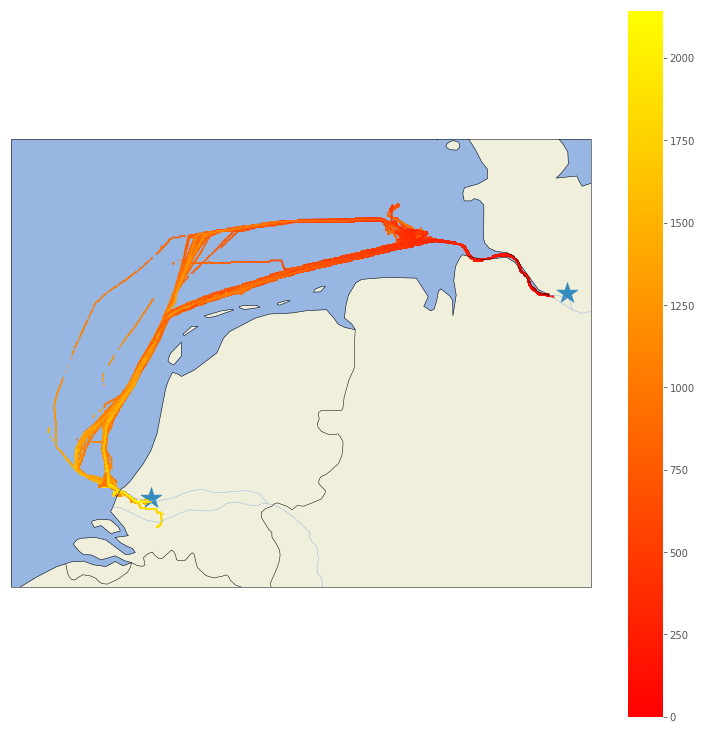

In [27]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [28]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
382931,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 08:38:00,184.0,26.0,...,3.90,14.0,349.0,347.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 09:53:00,2033.0
383053,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 07:10:00,184.0,26.0,...,4.08,6.0,40.0,26.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:21:00,2121.0
383129,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:46:00,184.0,26.0,...,4.05,1.6,175.0,292.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:45:00,2145.0
383130,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:49:00,184.0,26.0,...,4.05,1.3,267.0,12.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:42:00,2142.0
383131,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:52:00,184.0,26.0,...,4.05,1.0,89.0,75.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:39:00,2139.0


Text(0.5,1,u'Longest Trip in the Data Set')

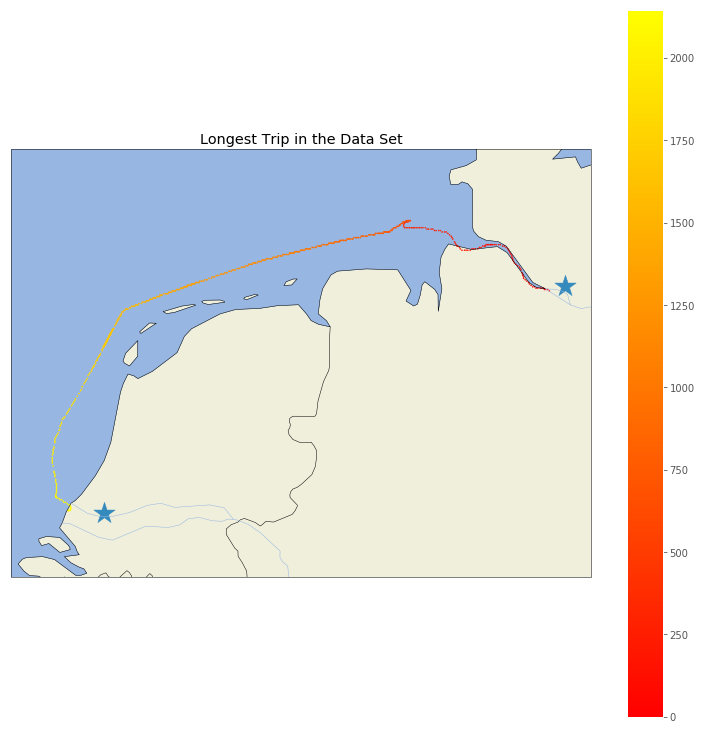

In [29]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [30]:
ais_dists = ais_shortmaj
ais_dists.is_copy = False

ais_dists['dist_to_end'] = ais_dists.apply(lambda x : aismap.route_dist_to_ham(x['Latitude'], x['Longitude']), axis = 1)
ais_dists.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins,dist_to_end
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:04:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:05:00,425.0,146.827424
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:05:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:04:00,424.0,146.185516
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:06:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:03:00,423.0,146.185516
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:07:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:02:00,422.0,145.544334
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:08:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:01:00,421.0,144.903944


In [31]:
ais_tfeats = ais_dists
ais_tfeats.is_copy = False

ais_tfeats['hour_of_day'] = ais_tfeats['time'].dt.hour
ais_tfeats['weekday'] = ais_tfeats['time'].dt.dayofweek
ais_tfeats['day_of_month'] = ais_tfeats['time'].dt.day
ais_tfeats['month'] = ais_tfeats['time'].dt.month

In [32]:
ais_tfeats['weekday'].describe()

count    831853.000000
mean          2.947164
std           1.955274
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: weekday, dtype: float64

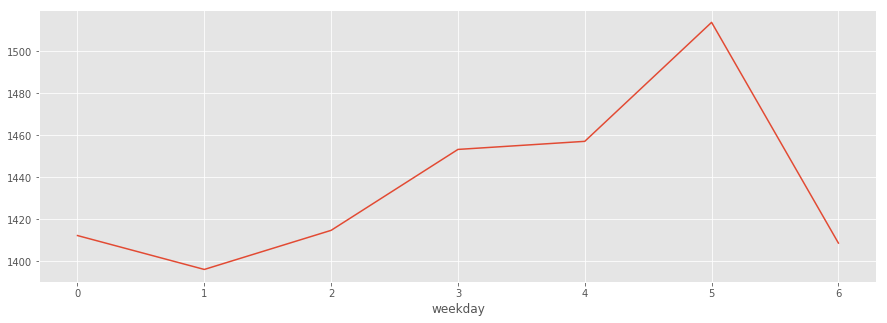

In [33]:
ais_tfeats.groupby('weekday')['TravelTimeMins'].mean().plot(figsize = (15, 5))

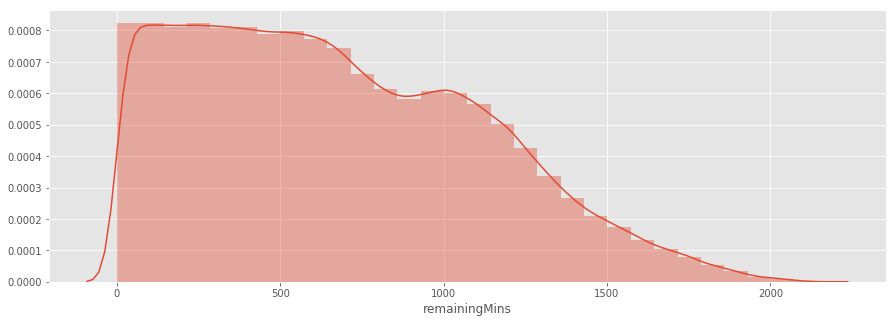

In [34]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['remainingMins'], bins = 30)

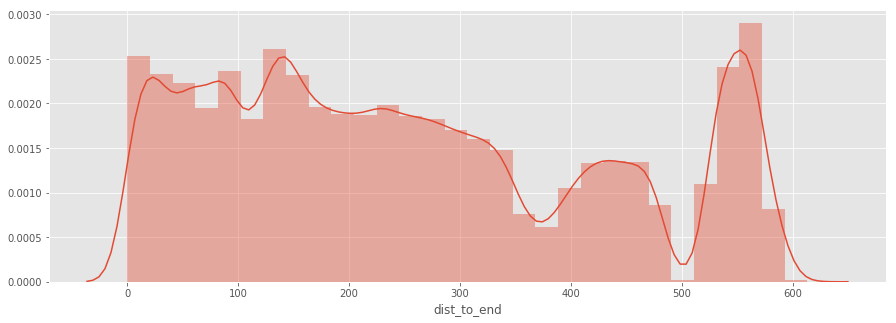

In [35]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['dist_to_end'], bins = 30)

In [81]:
# Downsample to get the data set a bit smaller
ais_downsampled = ais_tfeats
ais_downsampled.is_copy = False

ais_downsampled.index = ais_downsampled['time']
ais_downsampled = ais_downsampled.groupby('TripID').apply(lambda x : x.resample('5T').mean()).reset_index()

In [82]:
print ais_tfeats.shape
print ais_downsampled.shape

(831853, 27)
(190884, 21)


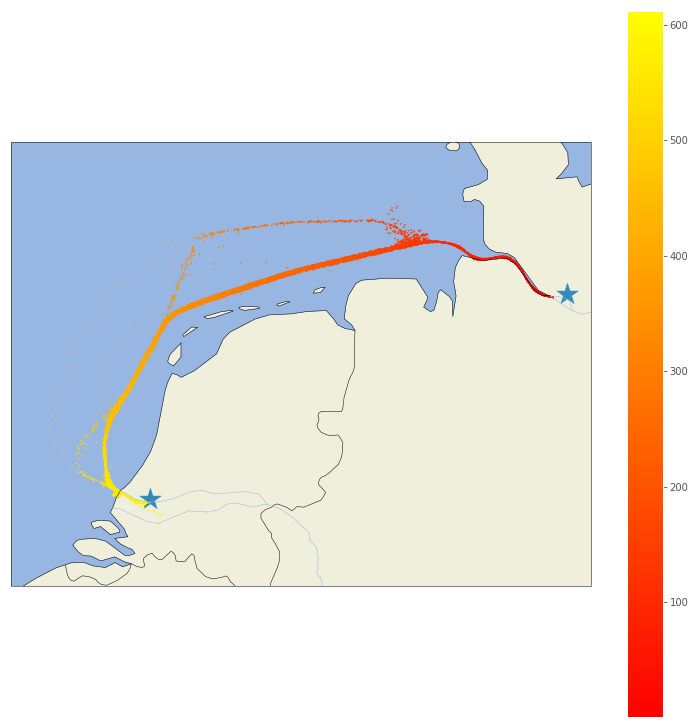

In [38]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_downsampled['Longitude'], latitude = ais_downsampled['Latitude'], col= ais_downsampled['dist_to_end'])

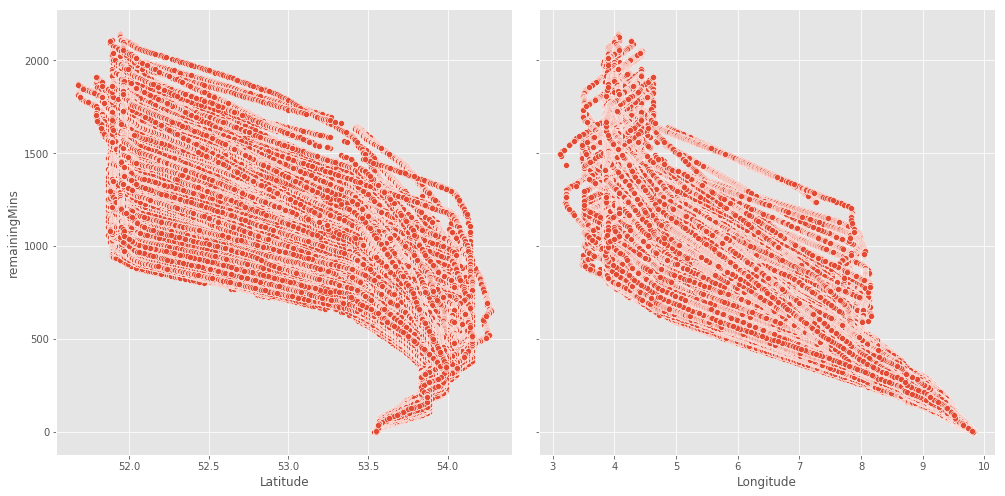

In [39]:
sns.pairplot(ais_tfeats, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

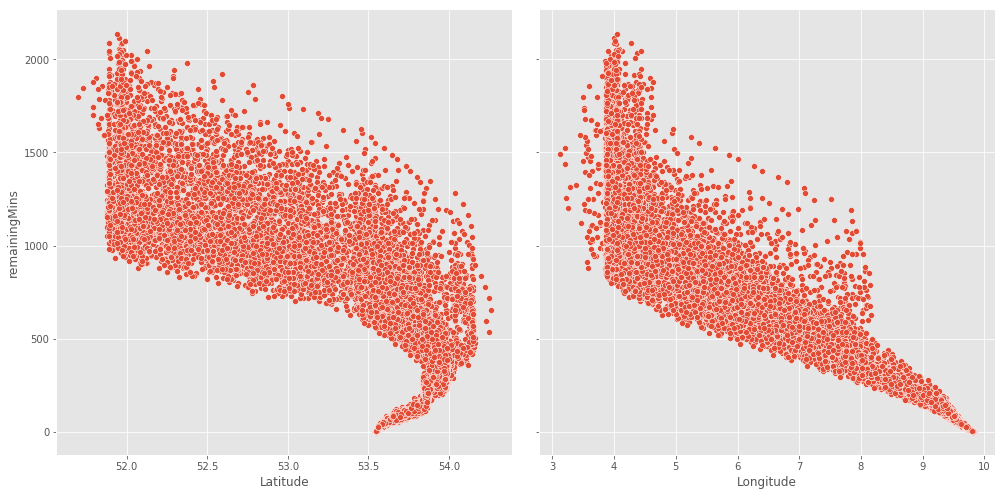

In [40]:
sns.pairplot(ais_downsampled, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

In [83]:
ais_downsampled.head()

,TripID,time,StartLatitude,StartLongitude,EndLatitude,EndLongitude,Length,Breadth,Draught,Latitude,...,SOG,COG,TH,TravelTimeMins,remainingMins,dist_to_end,hour_of_day,weekday,day_of_month,month
0,1000226,2016-06-15 14:55:00,51.97,4.03,53.5,9.93,369.0,51.0,13.8,51.97,...,5.20,112.633333,112.0,1494.0,1493.0,564.248455,14.0,2.0,15.0,6.0
1,1000226,2016-06-15 15:00:00,51.97,4.03,53.5,9.93,369.0,51.0,13.8,51.96,...,5.16,111.140000,110.6,1494.0,1489.0,565.488734,15.0,2.0,15.0,6.0
2,1000226,2016-06-15 15:05:00,51.97,4.03,53.5,9.93,369.0,51.0,13.8,51.96,...,5.98,111.920000,110.6,1494.0,1484.0,566.002304,15.0,2.0,15.0,6.0
3,1000226,2016-06-15 15:10:00,51.97,4.03,53.5,9.93,369.0,51.0,13.8,51.96,...,5.50,108.420000,110.6,1494.0,1479.0,566.521679,15.0,2.0,15.0,6.0
4,1000226,2016-06-15 15:15:00,51.97,4.03,53.5,9.93,369.0,51.0,13.8,51.96,...,5.04,50.140000,54.4,1494.0,1474.0,567.046734,15.0,2.0,15.0,6.0


In [84]:
ais_downsampled.columns

Index([u'TripID', u'time', u'StartLatitude', u'StartLongitude', u'EndLatitude',
       u'EndLongitude', u'Length', u'Breadth', u'Draught', u'Latitude',
       u'Longitude', u'SOG', u'COG', u'TH', u'TravelTimeMins',
       u'remainingMins', u'dist_to_end', u'hour_of_day', u'weekday',
       u'day_of_month', u'month'],
      dtype='object')

In [43]:
ais_learners = ais_downsampled[['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
                             'SOG', 'COG', 'TH', 'weekday', 'remainingMins', 'dist_to_end','month']]
ais_learners = ais_learners.dropna()
ais_learners.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Length,15714.0,257.742800,90.737272,82.000000,184.000000,262.000000,337.000000,400.000000
Breadth,15714.0,36.255269,11.984869,12.000000,27.000000,32.000000,48.000000,59.000000
Draught,15714.0,10.039978,2.436107,0.600000,8.010000,10.220000,11.800000,14.210000
Latitude,15714.0,53.345193,0.671141,51.699565,52.883262,53.617251,53.856414,54.258333
Longitude,15714.0,6.400424,2.043683,3.125556,4.318705,6.210667,8.262792,9.830000
SOG,15714.0,13.130514,3.953511,0.300000,10.857264,13.148518,15.731645,23.992308
COG,15714.0,100.818760,68.814062,1.400000,70.268220,77.773333,119.419545,356.262069
TH,15714.0,103.548847,72.940540,3.588235,69.568182,77.850000,121.279167,356.836364
weekday,15714.0,2.948454,1.959695,0.000000,1.000000,3.000000,5.000000,6.000000
remainingMins,15714.0,706.116587,456.272162,0.000000,319.958333,676.537158,1049.194646,2139.000000


In [85]:
X = ais_learners[['SOG', 'dist_to_end', 'TH', 'Latitude', 'Longitude', 'Length', 'Breadth', 'month']]
y = ais_learners['remainingMins']

In [86]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = ais_learners['TripID']))

In [87]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [88]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin_params = dict(normalize = [True, False])
lin_grid = GridSearchCV(lin, lin_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error')
lin_grid.fit(X, y)

pd.DataFrame(lin_grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_normalize,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0074,0.0006,-94.738262,-94.412705,True,{u'normalize': True},1,-89.45038,-95.04084,-114.103866,...,-90.267712,-94.991522,-93.111723,-94.543906,-85.419236,-95.433662,0.001356,0.000490,8.152942,1.053345
1,0.0093,0.0003,-94.738262,-94.412705,False,{u'normalize': False},2,-89.45038,-95.04084,-114.103866,...,-90.267712,-94.991522,-93.111723,-94.543906,-85.419236,-95.433662,0.006768,0.000458,8.152942,1.053345


In [48]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(40, 50), weights = [ 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 5)
knn_rand.fit(X, y)

pd.DataFrame(knn_rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0171,0.0376,-83.402072,-3.376155e-17,40,distance,"{u'n_neighbors': 40, u'weights': u'distance'}",1,-82.435624,-4.822006e-17,...,-77.391297,-4.821666e-17,-89.936287,-4.821666e-17,-68.127570,-0.0,0.006655,0.012729,8.542349,2.210213e-17
1,0.0162,0.0300,-83.466388,-3.376155e-17,41,distance,"{u'n_neighbors': 41, u'weights': u'distance'}",2,-82.404085,-4.822006e-17,...,-77.430866,-4.821666e-17,-90.074370,-4.821666e-17,-68.129820,-0.0,0.002926,0.009716,8.572696,2.210213e-17
2,0.0212,0.0464,-83.890757,-3.376155e-17,45,distance,"{u'n_neighbors': 45, u'weights': u'distance'}",3,-82.791623,-4.822006e-17,...,-77.836292,-4.821666e-17,-90.697221,-4.821666e-17,-68.140681,-0.0,0.006983,0.013192,8.668647,2.210213e-17
3,0.0214,0.0484,-84.158863,-3.376155e-17,48,distance,"{u'n_neighbors': 48, u'weights': u'distance'}",5,-83.068244,-4.822006e-17,...,-77.948503,-4.821666e-17,-91.086281,-4.821666e-17,-68.142488,-0.0,0.006391,0.015403,8.742913,2.210213e-17
4,0.0170,0.0351,-84.001045,-3.376155e-17,46,distance,"{u'n_neighbors': 46, u'weights': u'distance'}",4,-82.930882,-4.822006e-17,...,-77.876784,-4.821666e-17,-90.821369,-4.821666e-17,-68.168453,-0.0,0.003162,0.009027,8.699452,2.210213e-17


In [95]:
knn_best = KNeighborsRegressor(n_neighbors = 80, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(X_test)

In [96]:
knn_predicts_diffs = knn_predicts - y_test

In [97]:
knn_predicts_frame = pd.DataFrame({'correct': y_test, 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

count    1568.000000
mean       84.750381
std       100.954246
min         0.000000
25%         9.646945
50%        44.723691
75%       130.934591
max       614.524113
Name: abs_error, dtype: float64

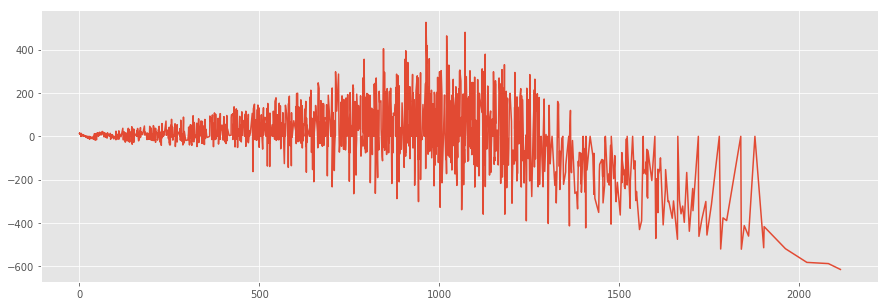

In [52]:
plt.figure(figsize = (15, 5))
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])

In [53]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

pd.DataFrame(rfo_rand.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.0908,0.0003,-76.185021,-57.800116,10,2,"{u'n_estimators': 2, u'max_depth': 10}",5,-69.162558,-58.436313,...,-71.357191,-58.352308,-75.208889,-58.284484,-74.935853,-57.529674,0.010038,0.000640,5.681766,0.865119
1,0.1781,0.0005,-76.920350,-73.204228,6,6,"{u'n_estimators': 6, u'max_depth': 6}",6,-69.561391,-74.357034,...,-71.711916,-73.693440,-75.614359,-73.519253,-75.761896,-73.576342,0.008443,0.000671,7.161877,1.264407
2,0.3703,0.0069,-71.899213,-49.540590,11,7,"{u'n_estimators': 7, u'max_depth': 11}",2,-64.591238,-50.339354,...,-66.715208,-49.611901,-71.844254,-49.423510,-70.632629,-49.938942,0.056091,0.007148,6.601325,0.656321
3,0.5261,0.0030,-72.889520,-37.357837,14,7,"{u'n_estimators': 7, u'max_depth': 14}",4,-65.673206,-37.866624,...,-67.782085,-37.733117,-71.828451,-36.536335,-70.974322,-38.201834,0.085217,0.005215,6.429760,0.833860
4,0.3558,0.0025,-72.136709,-50.136383,11,6,"{u'n_estimators': 6, u'max_depth': 11}",3,-64.601607,-51.470100,...,-66.357854,-51.071351,-70.579522,-50.323724,-69.836507,-50.265685,0.076897,0.003557,6.909802,0.924088
5,0.0450,0.0031,-81.426624,-62.822637,10,1,"{u'n_estimators': 1, u'max_depth': 10}",9,-73.088471,-64.282430,...,-78.349626,-63.001009,-78.684524,-62.883346,-83.285732,-63.682445,0.006465,0.005957,5.409714,1.360268
6,0.0462,0.0002,-79.255200,-66.657623,9,1,"{u'n_estimators': 1, u'max_depth': 9}",7,-67.995471,-67.599310,...,-76.536601,-67.524290,-76.544174,-67.080008,-78.165514,-67.151534,0.005564,0.000400,7.082986,1.251419
7,0.2811,0.0006,-80.571526,-78.055859,5,9,"{u'n_estimators': 9, u'max_depth': 5}",8,-72.117240,-78.864995,...,-75.606110,-78.278424,-79.573367,-78.060062,-78.541291,-78.534874,0.071198,0.000800,8.192290,0.882064
8,0.4382,0.0028,-71.562105,-54.156243,10,8,"{u'n_estimators': 8, u'max_depth': 10}",1,-63.925462,-54.722129,...,-65.436227,-54.711886,-69.018688,-54.218013,-71.569309,-54.613883,0.088960,0.004729,6.740974,0.736794
9,0.0614,0.0000,-88.720754,-45.783265,14,1,"{u'n_estimators': 1, u'max_depth': 14}",10,-79.810529,-48.910695,...,-81.767084,-44.949915,-91.844204,-45.071417,-87.128675,-45.980477,0.004883,0.000000,6.088863,1.516958


In [93]:
rfo_best = RandomForestRegressor(n_estimators = 10, max_depth = 15)
rfo_best.fit(X_train, y_train)

rfo_predicts = rfo_best.predict(X_test)
rfo_predicts_diffs = rfo_predicts - y_test

rfo_predicts_frame = pd.DataFrame({'correct': y_test, 'rfo_predicted': rfo_predicts, 'diff': rfo_predicts_diffs})
rfo_predicts_frame['abs_error'] = rfo_predicts_frame['diff'].transform(lambda x: abs(x))
rfo_predicts_frame = rfo_predicts_frame.sort_values('correct')
rfo_predicts_frame['abs_error'].describe()

count    1568.000000
mean       63.310698
std        83.015831
min         0.000000
25%        10.980549
50%        33.762425
75%        82.208213
max       676.638145
Name: abs_error, dtype: float64

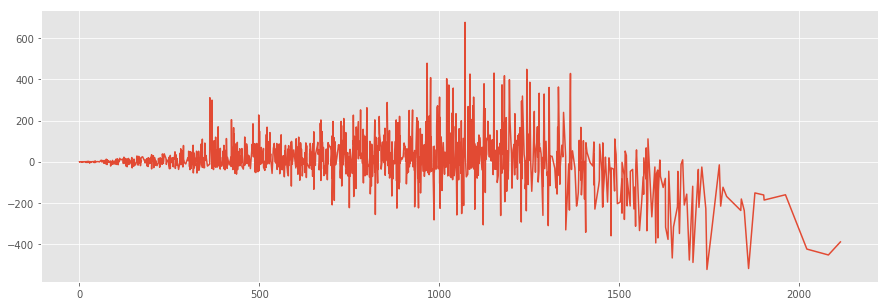

In [94]:
plt.figure(figsize = (15, 5))
plt.plot(rfo_predicts_frame['correct'], rfo_predicts_frame['diff'])

In [89]:
from sklearn.model_selection import train_test_split
ann_X_train, ann_X_test, ann_y_train, ann_y_test = train_test_split(X, y)

In [90]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=1000, hidden_layer_sizes=(50, 50), solver = 'lbfgs', random_state=1, learning_rate = 'adaptive')

mlp.fit(ann_X_train, ann_y_train)                         


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [91]:
ann_predicts = mlp.predict(ann_X_test)
ann_predicts_diffs = ann_predicts - ann_y_test

ann_predicts_frame = pd.DataFrame({'correct': ann_y_test, 'ann_predicted': ann_predicts, 'diff': ann_predicts_diffs})
ann_predicts_frame['abs_error'] = ann_predicts_frame['diff'].transform(lambda x: abs(x))
ann_predicts_frame = ann_predicts_frame.sort_values('correct')
ann_predicts_frame['abs_error'].describe()

count    3929.000000
mean       78.018536
std       102.677257
min         0.002975
25%        13.366869
50%        40.092410
75%       103.056566
max       824.026649
Name: abs_error, dtype: float64

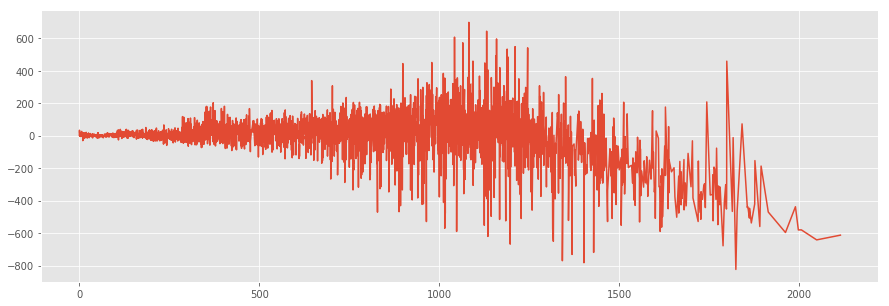

In [92]:
plt.figure(figsize = (15, 5))
plt.plot(ann_predicts_frame['correct'], ann_predicts_frame['diff'])

In [76]:

>>> from sklearn.model_selection import cross_val_score
score = cross_val_score(mlp, X, y, cv=10)
score

array([ 0.93418144,  0.90204159,  0.93140877,  0.9311649 ,  0.93446986,
        0.91634804,  0.88913375,  0.90680468,  0.93077157,  0.92096455])

In [77]:
score.mean() , score.std()

(0.91972891441524474, 0.01498068999087402)